# Install required libraries.

In [ ]:
!pip install torchvision
!pip install torch==1.13.1 torchvision==0.14.1
!pip install torchattacks

In [ ]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchattacks
from torch.utils.data import DataLoader
import torch.nn as nn

# Enable GPU

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA available! Training on GPU.", flush=True)
else:
    device = torch.device('cpu')
    print("CUDA NOT available... Training on CPU.", flush=True)


CUDA available! Training on GPU.


# Small CNN Architecture

This is an example of a small convolutional neural network that should take about a minute/epoch to train on FashionMNIST. The model has two convolutional layers and three fully connected layers.

To instantiate a SmallCNN model, call the SmallCNN function with parenthesis `model = SmallCNN()`. Once the model is instantiated, you can enable gradient computations by calling `model.train()` before a training loop. To disable gradient computations (e.g. when testing or performing inference), call `model.eval()`.

Training the model several times may take a while. To circumvent this once a model has been trained for each of the HW problems, use `torch.save(model, <filename>.pth)` and `torch.load(<filename.pth>)`.

In [ ]:
class SmallCNN(nn.Module):

    def __init__(self):
        super(SmallCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        return out

--------
# Loading Fashion-MNIST using PyTorch

In [ ]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T

# Set a constant seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


def load_fmnist_torch(root="./data", transform=None, download=True):

    if transform == None:
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Repeat grayscale image across 3 channels
            ])
    train_set = FashionMNIST(root=root,  transform=transform, download=download, train=True)
    test_set = FashionMNIST(root=root,  transform=transform, download=download, train=False)

    # Each item in this dictionary is a torch Dataset object
    # To feed the data into a model, you may have to use a DataLoader
    return {"train": train_set, "test": test_set}

# Problem 1

In [ ]:
# Load data
fmnist_data =  load_fmnist_torch()

In [ ]:
import torch.optim as optim

# Create an instance of the SmallCNN model
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders
trainloader = torch.utils.data.DataLoader(fmnist_data['train'], batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(fmnist_data['test'], batch_size=100, shuffle=False)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Test Accuracy: {100*correct/total:.2f}%')

Epoch 1/10, Test Accuracy: 88.47%
Epoch 2/10, Test Accuracy: 89.41%
Epoch 3/10, Test Accuracy: 88.39%
Epoch 4/10, Test Accuracy: 91.25%
Epoch 5/10, Test Accuracy: 91.61%
Epoch 6/10, Test Accuracy: 92.22%
Epoch 7/10, Test Accuracy: 92.08%
Epoch 8/10, Test Accuracy: 92.08%
Epoch 9/10, Test Accuracy: 91.78%
Epoch 10/10, Test Accuracy: 91.69%


## a)

In [ ]:
# Select 100 images from the test dataset
data_iter =  next(iter(testloader)) # YOUR CODE HERE

# Get from iterator
test_images, test_labels =  data_iter[0].to(device), data_iter[1].to(device) # YOUR CODE HERE

In [ ]:
from torchattacks import CW

# Instantiating the attack instance
attack = CW(model=model, c=500, kappa=0, steps=50, lr=0.1)

# Get adversarial images
adv_images = attack(test_images, test_labels)

In [ ]:
perturbations = torch.norm((adv_images - test_images).view(100, -1), p=2, dim=1).cpu().numpy()

In [ ]:
# Evaluate adversarial success
model.eval()
with torch.no_grad():
    orig_outputs = model(test_images)
    adv_outputs = model(adv_images)

    _, orig_predicted = orig_outputs.max(1)
    _, adv_predicted = adv_outputs.max(1)

    success = (adv_predicted != test_labels) & (orig_predicted == test_labels)
    success = success.cpu().numpy()

# Sort perturbations and corresponding success flags
sorted_indices = np.argsort(perturbations)
sorted_perturbations = perturbations[sorted_indices]
sorted_success = success[sorted_indices]

# Calculate cumulative success rate
cumulative_success = np.cumsum(sorted_success) / np.arange(1, 101)

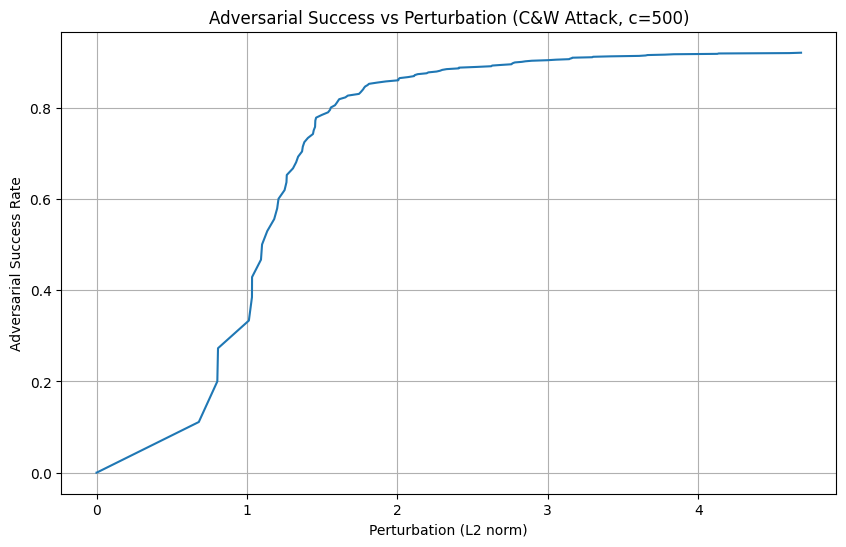

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_perturbations, cumulative_success)
plt.xlabel('Perturbation (L2 norm)')
plt.ylabel('Adversarial Success Rate')
plt.title('Adversarial Success vs Perturbation (C&W Attack, c=500)')
plt.grid(True)
plt.show()

Plotting Sample Graph for C=0.00001 and C=1000.

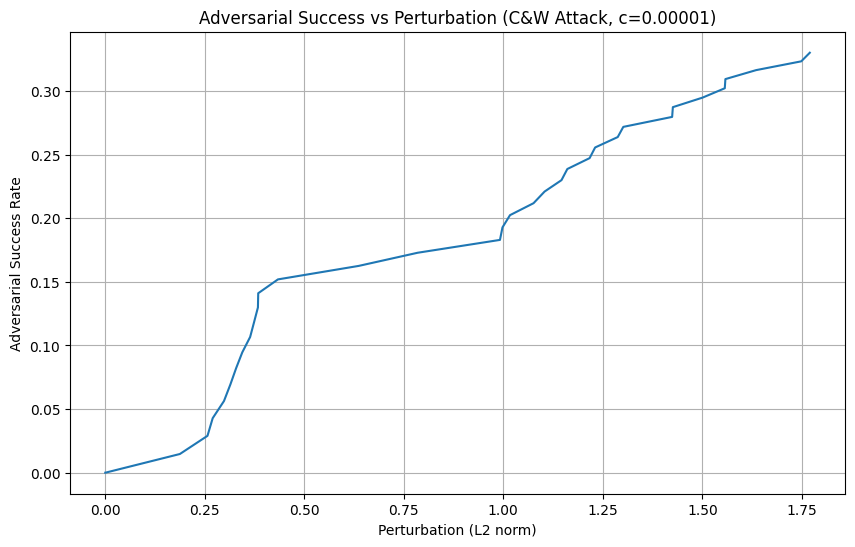

In [ ]:
# Instantiating the attack instance
attack = CW(model=model, c=0.00001, kappa=0, steps=50, lr=0.1)

# Get adversarial images
adv_images = attack(test_images, test_labels)

perturbations = torch.norm((adv_images - test_images).view(100, -1), p=2, dim=1).cpu().numpy()

# Evaluate adversarial success
model.eval()
with torch.no_grad():
    orig_outputs = model(test_images)
    adv_outputs = model(adv_images)

    _, orig_predicted = orig_outputs.max(1)
    _, adv_predicted = adv_outputs.max(1)

    success = (adv_predicted != test_labels) & (orig_predicted == test_labels)
    success = success.cpu().numpy()

# Sort perturbations and corresponding success flags
sorted_indices = np.argsort(perturbations)
sorted_perturbations = perturbations[sorted_indices]
sorted_success = success[sorted_indices]

# Calculate cumulative success rate
cumulative_success = np.cumsum(sorted_success) / np.arange(1, 101)


# Plotting adversarial success
plt.figure(figsize=(10, 6))
plt.plot(sorted_perturbations, cumulative_success)
plt.xlabel('Perturbation (L2 norm)')
plt.ylabel('Adversarial Success Rate')
plt.title('Adversarial Success vs Perturbation (C&W Attack, c=0.00001)')
plt.grid(True)
plt.show()

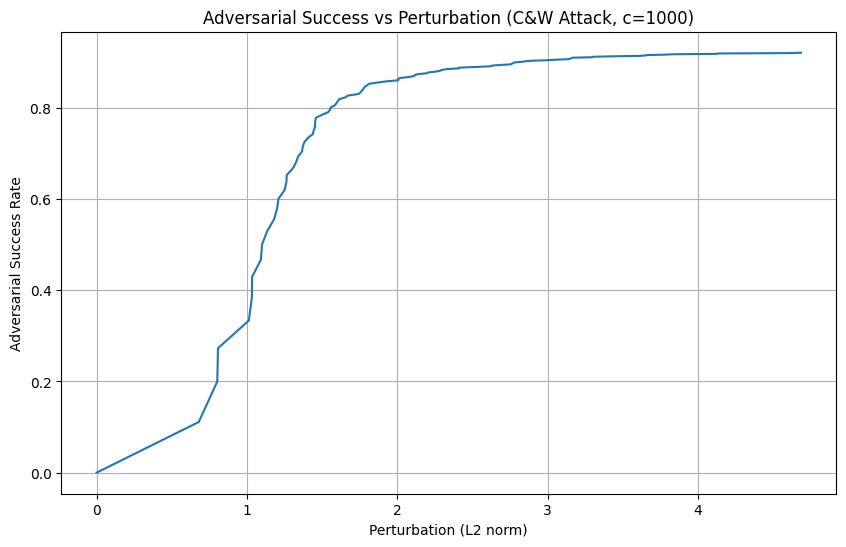

In [ ]:
# Instantiating the attack instance
attack = CW(model=model, c=1000, kappa=0, steps=50, lr=0.1)

# Get adversarial images
adv_images = attack(test_images, test_labels)

perturbations = torch.norm((adv_images - test_images).view(100, -1), p=2, dim=1).cpu().numpy()

# Evaluate adversarial success
model.eval()
with torch.no_grad():
    orig_outputs = model(test_images)
    adv_outputs = model(adv_images)

    _, orig_predicted = orig_outputs.max(1)
    _, adv_predicted = adv_outputs.max(1)

    success = (adv_predicted != test_labels) & (orig_predicted == test_labels)
    success = success.cpu().numpy()

# Sort perturbations and corresponding success flags
sorted_indices = np.argsort(perturbations)
sorted_perturbations = perturbations[sorted_indices]
sorted_success = success[sorted_indices]

# Calculate cumulative success rate
cumulative_success = np.cumsum(sorted_success) / np.arange(1, 101)


# Plotting adversarial success
plt.figure(figsize=(10, 6))
plt.plot(sorted_perturbations, cumulative_success)
plt.xlabel('Perturbation (L2 norm)')
plt.ylabel('Adversarial Success Rate')
plt.title('Adversarial Success vs Perturbation (C&W Attack, c=1000)')
plt.grid(True)
plt.show()

For higher c values (500 and 1000), the adversarial success rate rises steeply with perturbation, quickly reaching over 90% success with moderate perturbations around 1 to 2.

This indicates that these settings lead to a more effective attack, where a relatively small perturbation results in high success. In contrast, with a much smaller c=0.00001, the adversarial success rate remains low, never exceeding 30%, even as perturbation increases.

This shows that a lower c value results in a weaker attack, where even larger perturbations are insufficient to achieve high success. Overall, the parameter c plays a critical role in determining the attack's success, with larger values enabling more efficient adversarial attacks.

## c)

In [ ]:
# Calculate everything again for c=500
# Instantiating the attack instance
attack = CW(model=model, c=500, kappa=0, steps=50, lr=0.1)

# Get adversarial images
adv_images = attack(test_images, test_labels)

perturbations = torch.norm((adv_images - test_images).view(100, -1), p=2, dim=1).cpu().numpy()

# Evaluate adversarial success
model.eval()
with torch.no_grad():
    orig_outputs = model(test_images)
    adv_outputs = model(adv_images)

    _, orig_predicted = orig_outputs.max(1)
    _, adv_predicted = adv_outputs.max(1)

    success = (adv_predicted != test_labels) & (orig_predicted == test_labels)
    success = success.cpu().numpy()

# Sort perturbations and corresponding success flags
sorted_indices = np.argsort(perturbations)
sorted_perturbations = perturbations[sorted_indices]
sorted_success = success[sorted_indices]

# Calculate cumulative success rate
cumulative_success = np.cumsum(sorted_success) / np.arange(1, 101)

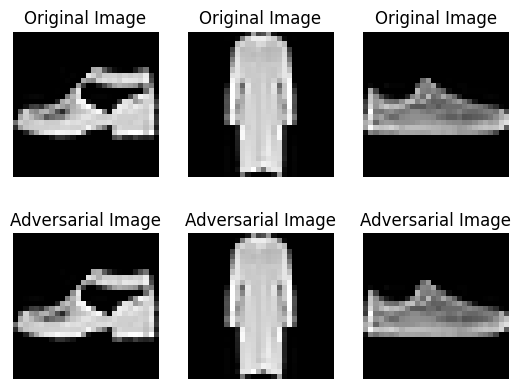

In [ ]:
# Top 3 samples of minimum perturbations
min_indices = np.argsort(perturbations)[:3]
min_orig_images = test_images[min_indices]
min_adv_images = adv_images[min_indices]

# TOp 3 samples of maximum perturbations
max_indices = np.argsort(perturbations)[-3:]
max_orig_images = test_images[max_indices]
max_adv_images = adv_images[max_indices]

fig, ax = plt.subplots(2, 3)
# Visualize the original image and adversarial image

for i in range(3):
  ax[0][i].imshow(min_orig_images[i].cpu().numpy().transpose(1, 2, 0))
  ax[0][i].set_title('Original Image')
  ax[0][i].set_axis_off()

  ax[1][i].imshow(min_adv_images[i].cpu().numpy().transpose(1, 2, 0))
  ax[1][i].set_title('Adversarial Image')
  ax[1][i].set_axis_off()


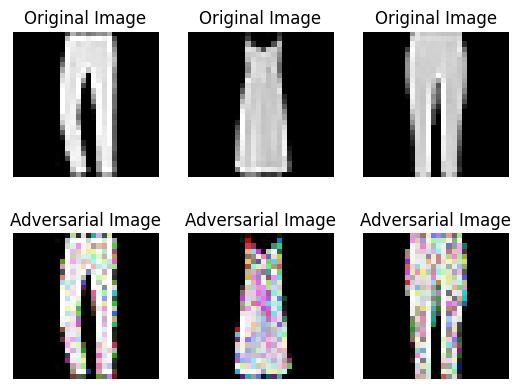

In [ ]:
fig, ax = plt.subplots(2, 3)
# Visualize the original image and adversarial image

for i in range(3):
  ax[0][i].imshow(max_orig_images[i].cpu().numpy().transpose(1, 2, 0))
  ax[0][i].set_title('Original Image')
  ax[0][i].set_axis_off()

  ax[1][i].imshow(max_adv_images[i].cpu().numpy().transpose(1, 2, 0))
  ax[1][i].set_title('Adversarial Image')
  ax[1][i].set_axis_off()


Observations for the above images

# Problem 2


In [ ]:
# YOUR CODE HERE
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Define model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Function to add backdoor trigger
def add_backdoor(images, positions, values):
    backdoored_images = np.copy(images)
    for pos, val in zip(positions, values):
        backdoored_images[:, pos[0], pos[1]] = val
    return backdoored_images

# Function to poison dataset
def poison_dataset(x, y, orig_class, target_class, positions, values, poison_ratio):
    class_indices = np.where(y == orig_class)[0]
    num_poison = int(len(class_indices) * poison_ratio)
    poison_indices = np.random.choice(class_indices, num_poison, replace=False)

    x_poison = add_backdoor(x[poison_indices], positions, values)
    y_poison = np.full(num_poison, target_class)

    x_poisoned = np.concatenate([x, x_poison])
    y_poisoned = np.concatenate([y, y_poison])

    return x_poisoned, y_poisoned

# Function to evaluate model
def evaluate_model(model, x_clean, y_clean, x_backdoor, y_backdoor):
    clean_loss, clean_acc = model.evaluate(x_clean, y_clean, verbose=0)
    backdoor_loss, backdoor_acc = model.evaluate(x_backdoor, y_backdoor, verbose=0)
    return clean_acc, backdoor_acc

# Experiment with different backdoor positions
positions_list = [
    [(27,27), (27,26), (26,27), (26,26)],  # Bottom right
    [(0,0), (0,1), (1,0), (1,1)],          # Top left
    [(13,13), (13,14), (14,13), (14,14)]   # Center
]

results = []

for positions in positions_list:
    # Poison dataset
    x_train_poisoned, y_train_poisoned = poison_dataset(
        x_train, y_train,
        orig_class=0, target_class=1,
        positions=positions, values=[1.0]*4,
        poison_ratio=0.01
    )

    # Train model
    model.fit(x_train_poisoned, y_train_poisoned, epochs=5, verbose=0)

    # Evaluate
    x_test_backdoor = add_backdoor(x_test, positions, [1.0]*4)
    clean_acc, backdoor_acc = evaluate_model(model, x_test, y_test, x_test_backdoor, y_test)

    results.append((positions, clean_acc, backdoor_acc))

# Print results
for positions, clean_acc, backdoor_acc in results:
    print(f"Positions: {positions}")
    print(f"Clean accuracy: {clean_acc:.4f}")
    print(f"Backdoor accuracy: {backdoor_acc:.4f}")
    print()

# Find best and worst results
best_result = max(results, key=lambda x: x[2])
worst_result = min(results, key=lambda x: x[2])

print("Best result:")
print(f"Positions: {best_result[0]}")
print(f"Clean accuracy: {best_result[1]:.4f}")
print(f"Backdoor accuracy: {best_result[2]:.4f}")
print()

print("Worst result:")
print(f"Positions: {worst_result[0]}")
print(f"Clean accuracy: {worst_result[1]:.4f}")
print(f"Backdoor accuracy: {worst_result[2]:.4f}")

# Experiment with different backdoor sizes and poison ratios
best_positions = best_result[0]

for b in [1, 4, 8]:
    for p in [0, 0.01, 0.05]:
        positions = best_positions[:b]
        values = [1.0] * b

        x_train_poisoned, y_train_poisoned = poison_dataset(
            x_train, y_train,
            orig_class=0, target_class=1,
            positions=positions, values=values,
            poison_ratio=p
        )

        model.fit(x_train_poisoned, y_train_poisoned, epochs=5, verbose=0)

        x_test_backdoor = add_backdoor(x_test, positions, values)
        clean_acc, backdoor_acc = evaluate_model(model, x_test, y_test, x_test_backdoor, y_test)

        print(f"Backdoor size: {b}, Poison ratio: {p}")
        print(f"Clean accuracy: {clean_acc:.4f}")
        print(f"Backdoor accuracy: {backdoor_acc:.4f}")
        print()

# Problem 3


In [ ]:
# Install
!pip install -U keras-nlp
!pip install -U keras
!pip install tensorflow-text

In [ ]:
# Imports
import keras
import keras_nlp
import numpy as np

In [ ]:
# Model
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(".")


In [ ]:
# YOUR CODE HERE

# Problem 4


In [ ]:
# YOUR CODE HERE